<a href="https://colab.research.google.com/github/Lorenzo-Gardini/DeepLearnig/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors
The authors of this code, this notebook and its documentation are [Lorenzo Gardini](mailto: lorenzo.gardini7@studio.unibo.it) and [Vlad Mattiussi](mailto: vlad.mattiussi@studio.unibo.it).

prendi spunto da https://colab.research.google.com/drive/1f9BxFxPxhPKUba8Ifcq4juv042ZA484-

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
%%capture
!pip install stable-baselines3[extra] ale-py==0.7.4 pyvirtualdisplay

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
import statistics
import cv2
import uuid
from IPython.display import HTML
from base64 import b64encode
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras import layers
from skimage import transform
from skimage.color import rgb2gray
from collections import deque
from pyvirtualdisplay import Display

# **Useful modules import**
First of all, it is necessary to import useful modules used during the tutorial.

# Utility functions

In [4]:
import gym
from gym.wrappers import RecordVideo

VIDEO_FOLDER = "./video"

def make_env():
  return gym.make("ALE/Freeway-v5")

## DQN
(action space incompatibile: dqn richiede solo discreto mentre l'env utilizza box.)

In [5]:
env = make_env()

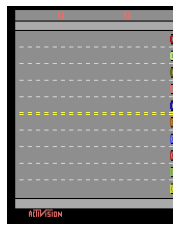

In [6]:
env.reset()
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img
plot_environment(env)  
plt.show()    

In [97]:
action = 1 
obs, reward, done, info = env.step(action)

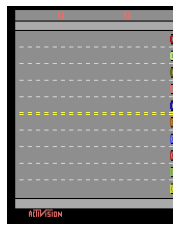

In [7]:
plot_environment(env)
plt.show()

In [30]:
print("The shape of the state space is: ", env.observation_space.shape)

The shape of the state space is:  (210, 160, 3)


In [29]:
print('There are {} possible actions'.format(env.action_space.n))

There are 3 possible actions


https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb

In [54]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [55]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [59]:
# extra code – this cell displays an animation of one episode
import matplotlib
import matplotlib.animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    plt.show()
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("ALE/Freeway-v5")
    np.random.seed(seed)
    obs = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        action = policy(obs)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return plot_animation(frames)

In [31]:
import tensorflow as tf
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model=keras.Sequential(            [
                layers.Input(shape=input_shape,name='Input'),
                layers.Conv2D(filters=32, kernel_size=8, strides=4,activation='relu',padding='valid',name='C1'),
                layers.Conv2D(filters=64, kernel_size=4,strides=2,activation='relu',padding='valid',name='C2'),
                layers.Conv2D(filters=64, kernel_size=3,strides=1,activation='relu',padding='valid',name='C3'),
                layers.Flatten(),
                layers.Dense(512, activation='relu',name='FC'),
                layers.Dense(units=n_outputs,activation='linear',name='Output')
            ]
        )

In [32]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis])[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [33]:
replay_buffer = deque(maxlen=2000)

In [34]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [35]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [36]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [37]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [38]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = next_Q_values.max(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [63]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 600, Steps: 200, eps: 0.010

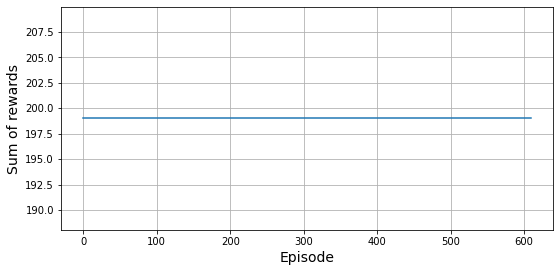

In [64]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

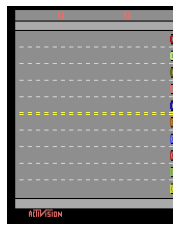

In [68]:
show_one_episode(epsilon_greedy_policy)

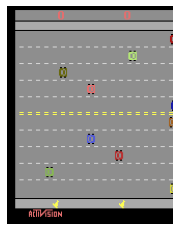

In [66]:
plot_environment(env)
plt.show()

Metodo visto a laboratorio

In [ ]:
def build_dqn(input_shape=(84, 84, 4),action_count=9):
    model=keras.Sequential(
            [
                layers.Input(shape=input_shape,name='Input'),
                layers.Conv2D(filters=32, kernel_size=8, strides=4,activation='relu',padding='valid',name='C1'),
                layers.Conv2D(filters=64, kernel_size=4,strides=2,activation='relu',padding='valid',name='C2'),
                layers.Conv2D(filters=64, kernel_size=3,strides=1,activation='relu',padding='valid',name='C3'),
                layers.Flatten(),
                layers.Dense(512, activation='relu',name='FC'),
                layers.Dense(units=action_count,activation='linear',name='Output')
            ]
        )
    return model

In [ ]:
dqn_action_model=build_dqn(action_count=env.action_space.n)
dqn_target_model=build_dqn(action_count=env.action_space.n)
dqn_target_model.set_weights(dqn_action_model.get_weights())

In [ ]:
dqn_action_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 20, 20, 32)        8224      
                                                                 
 C2 (Conv2D)                 (None, 9, 9, 64)          32832     
                                                                 
 C3 (Conv2D)                 (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 FC (Dense)                  (None, 512)               1606144   
                                                                 
 Output (Dense)              (None, 3)                 1539      
                                                                 
Total params: 1,685,667
Trainable params: 1,685,667
No

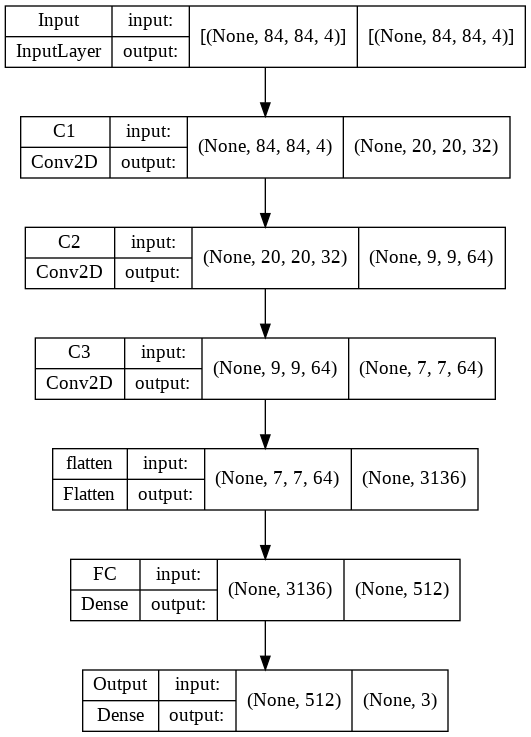

In [ ]:
keras.utils.plot_model(dqn_action_model,show_shapes=True, show_layer_names=True)

In [ ]:
learning_rate=0.00025

optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
dqn_action_model.compile(optimizer=optimizer, loss = 'huber') 

In [ ]:
def preprocess_frame(frame,top_crop,bottom_crop,left_crop,right_crop,resized_shape):
    # 1. the input RGB frame is transformed in grayscale
    gray = rgb2gray(frame)
        
    # 2. the region of interest is cropped
    cropped_frame = gray[top_crop:bottom_crop,left_crop:right_crop]
    
    # 3. the resulting images is resized
    preprocessed_frame = transform.resize(cropped_frame, resized_shape)
    
    # convert float to byte
    byte_preprocessed_frame=(preprocessed_frame*255).astype('uint8')

    return byte_preprocessed_frame

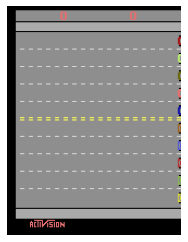

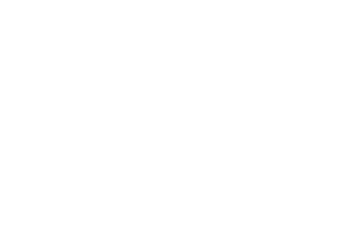

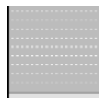

In [ ]:
top_crop = 30             # y coordinate of the top of the region of interest
bottom_crop = 195         # y coordinate of the bottom of the region of interest
left_crop = 5             # x coordinate of the left of the region of interest
right_crop = 155          # x coordinate of the right of the region of interest
resized_shape = (84,84)   # shape of the resized frame

preprocessed_prev_frame=preprocess_frame(prev_screen,top_crop,bottom_crop,left_crop,right_crop,resized_shape)

dpi=50

plt.figure(figsize=(prev_screen.shape[1]/dpi,prev_screen.shape[0]/dpi))
plt.axis('off')
plt.imshow(prev_screen)
plt.show()

plt.axis('off')
plt.figure(figsize=(preprocessed_prev_frame.shape[1]/dpi,preprocessed_prev_frame.shape[0]/dpi))
plt.axis('off')
plt.imshow(preprocessed_prev_frame.squeeze(),cmap='gray')
plt.show()

In [ ]:
def stack_frames(new_frame,frame_count,deque_frames=None):
  if deque_frames is None:
    deque_frames = deque([new_frame for i in range(frame_count)],maxlen=frame_count)
  else:
    deque_frames.append(new_frame)

  return np.stack(deque_frames, axis=2),deque_frames

In [ ]:
def plot_training_rewards(rewards,moving_avg_window_size=None):
  if moving_avg_window_size is not None:
    moving_avg_total_reward=[]
    for i in range(len(rewards)):
      window=rewards[max(0,i-moving_avg_window_size+1):i+1]
      window_avg=statistics.mean(window)
      moving_avg_total_reward.append(window_avg)

  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(range(len(rewards)),rewards,label='Total reward',color='orange')
  ax.set_xlabel('Episodes')
  if moving_avg_window_size is not None:
    ax.plot(range(len(moving_avg_total_reward)),moving_avg_total_reward,label='Total reward moving average')
    ax.legend(loc='upper left')

def plot_stacked_frames(stacked_frames):
  _,axs=plt.subplots(1,stacked_frames.shape[2],figsize=(15,5))
  for i in range(stacked_frames.shape[2]):
    axs[i].axis('off')
    axs[i].imshow(stacked_frames[:,:,i],cmap='gray')

def create_mp4_video_from_frames(frames,fps):
  temp_video_path='tempfile.mp4'
  compressed_path='{}.mp4'.format(str(uuid.uuid4()))
  
  size=(frames[0].shape[1],frames[0].shape[0])
  out = cv2.VideoWriter(temp_video_path,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
  
  for i in range(len(frames)):
      out.write(frames[i][...,::-1].copy())  #rgb[...,::-1].copy()
  out.release()

  os.system(f"ffmpeg -i {temp_video_path} -vcodec libx264 {compressed_path}")

  os.remove(temp_video_path)

  return compressed_path

Shape of the stacked frames (84, 84, 4)


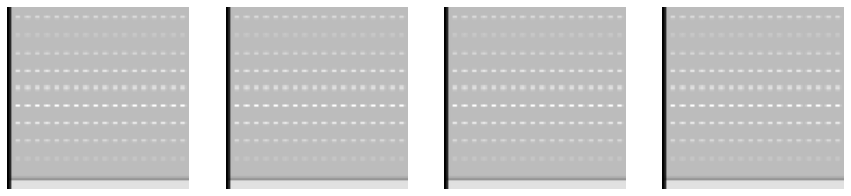

In [ ]:
stacked_frame_count=4     # number of stacked frames

stacked_frames,deque_frames=stack_frames(preprocessed_prev_frame,stacked_frame_count)

print('Shape of the stacked frames',stacked_frames.shape)

plot_stacked_frames(stacked_frames)

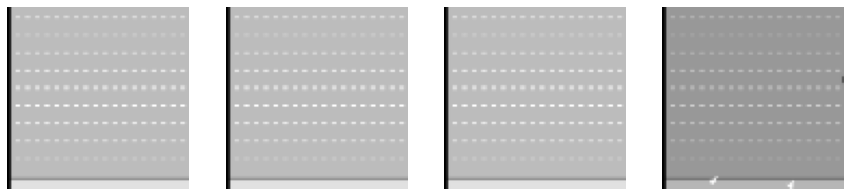

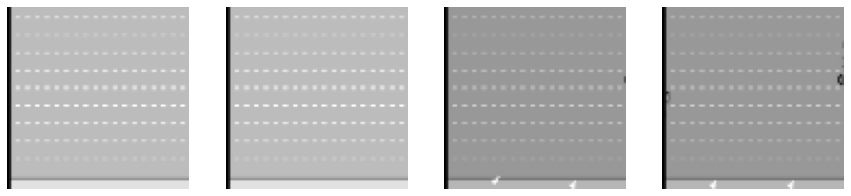

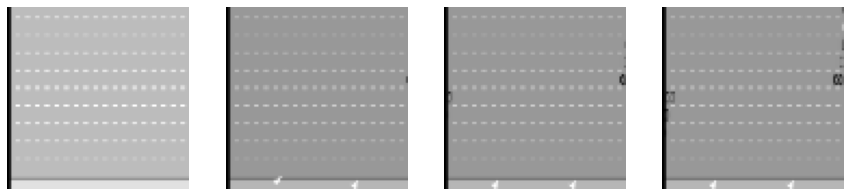

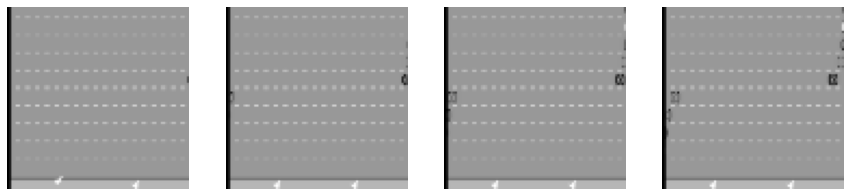

In [ ]:
step_count=4

for i in range(step_count):
  new_state,_,_,_=env.step(1 if i==0 else env.action_space.sample())  # the first action is 'fire' to start the game
  new_frame=preprocess_frame(new_state,top_crop,bottom_crop,left_crop,right_crop,resized_shape)
  stacked_frames,deque_frames=stack_frames(new_frame,stacked_frame_count,deque_frames)
  plot_stacked_frames(stacked_frames)

In [ ]:
def dqn_replay_memory_init(env,replay_memory,replay_memory_init_size,episode_max_steps,
                           top_crop,bottom_crop,left_crop,right_crop,resized_shape,stacked_frame_count):
    while True:
        state = env.reset()

        # the state is preprocessed to obtain the initial frame
        frame = preprocess_frame(state,top_crop,bottom_crop,left_crop,right_crop,resized_shape)
        
        # a new stack of frames is created from the initial frame 
        stacked_frames,deque_frames = stack_frames(frame,stacked_frame_count)

        done=False
        step_count=0
        while (step_count<episode_max_steps) and (not done):
            action = env.action_space.sample()
            new_state, reward, done, _ = env.step(action)

            # the new frame is obtained by new state preprocessing
            new_frame = preprocess_frame(new_state,top_crop,bottom_crop,left_crop,right_crop,resized_shape)
            
            # the stack is updated by adding the new frame and removing the oldest one
            new_stacked_frames,deque_frames = stack_frames(new_frame,stacked_frame_count,deque_frames)

            replay_memory.append([stacked_frames,action,reward,new_stacked_frames,done])
            stacked_frames=new_stacked_frames
            step_count+=1
            if len(replay_memory)>=replay_memory_init_size:
                return

In [ ]:
def dqn_update(dqn_action_model,dqn_target_model,mini_batch,gamma):
  # the transition mini-batch is divided into a mini-batch for each element of a transition
  state_batch,action_batch,reward_batch,new_state_batch,done_batch=mini_batch

  # pixel values are normalized in the range [0;1]
  norm_state_batch=state_batch/255.0
  norm_new_state_batch=new_state_batch/255.0

  # find the target model Q values for all possible actions given the new state batch
  target_new_state_q_values = dqn_target_model.predict(norm_new_state_batch)
  
  # find the action model Q values for all possible actions given the current state batch
  predicted_state_q_values = dqn_action_model.predict(norm_state_batch)
  
  # estimate the target values y_i
  # for the action we took, use the target model Q values  
  # for other actions, use the action model Q values
  # in this way, loss function will be 0 for other actions
  for i,(a,r,new_state_q_values, done) in enumerate(zip(action_batch,reward_batch,target_new_state_q_values, done_batch)): 
      if not done:  
        target_value = r + gamma * np.amax(new_state_q_values)
      else:         
        target_value = r
      predicted_state_q_values[i][a] = target_value #y_i
  
  # update weights of action model using the train_on_batch method 
  dqn_action_model.train_on_batch(norm_state_batch, predicted_state_q_values)
  
  # return the updated action model
  return dqn_action_model

In [ ]:
def dqn_training(env,dqn_action_model,dqn_target_model,episode_count,episode_max_steps,replay_memory_max_size,replay_memory_init_size,
                 batch_size,step_per_update,step_per_update_target_model,max_epsilon,min_epsilon,epsilon_decay,gamma,
                 top_crop,bottom_crop,left_crop,right_crop,resized_shape,stacked_frame_count,
                 moving_avg_window_size=100,moving_avg_stop_thr=None):
    # experience replay memory declaration
    replay_memory= deque(maxlen=replay_memory_max_size)
    
    # 1. replay memory initial population
    if replay_memory_init_size>0:
        print('Replay memory initial population')
        dqn_replay_memory_init(env,
                               replay_memory,
                               replay_memory_init_size,
                               episode_max_steps,
                               top_crop,
                               bottom_crop,
                               left_crop,
                               right_crop,
                               resized_shape,
                               stacked_frame_count)

    # inizialize epsilon equal to max_epsilon
    epsilon = max_epsilon

    train_rewards=[] # for visualization purposes

    train_step_count=0 #T
    for n in range(episode_count): 
        # for visualization purposes
        episode_start_time = time.time()    
        episode_reward = 0
        episode_start_epsilon=epsilon

        # reset the environment
        state = env.reset()

        # 2. the state is preprocessed to obtain the initial frame
        frame = preprocess_frame(state,top_crop,bottom_crop,left_crop,right_crop,resized_shape)
        
        # 3. a new stack of frames is created from the initial frame
        stacked_frames,deque_frames = stack_frames(frame,stacked_frame_count)

        step_count=0  #t
        done=False
        while step_count<episode_max_steps and not done: 
            # decide whether to pick a random action or to exploit the already computed Q-values
            if random.uniform(0,1) <= epsilon:
                action = env.action_space.sample()
            else:
                # 4. stacked frame normalization
                norm_stacked_frames=stacked_frames/255.0
                q_values = dqn_action_model.predict(norm_stacked_frames[np.newaxis])
                action = np.argmax(q_values)
            
            # take the action and observe the outcome state and reward
            new_state, reward, done, _ = env.step(action)
            
            # 5. the new state is preprocessed to obtain the new frame
            new_frame = preprocess_frame(new_state,top_crop,bottom_crop,left_crop,right_crop,resized_shape)

            # 6. the stack of frames is updated by adding the new frame and removing the oldest one
            new_stacked_frames,deque_frames = stack_frames(new_frame,stacked_frame_count,deque_frames)

            # store transition in the replay memory
            replay_memory.append([stacked_frames,action,reward,new_stacked_frames,done])
            
            # update the current state
            stacked_frames=new_stacked_frames
                        
            if train_step_count % step_per_update == 0 and len(replay_memory)>=batch_size:
                # get a random mini-batch from the replay memory
                mini_batch=get_random_batch_from_replay_memory(replay_memory,batch_size)
                # 7. update the action model weights
                dqn_action_model=dqn_update(dqn_action_model,dqn_target_model,mini_batch,gamma)
                
            if train_step_count % step_per_update_target_model ==0:
                # copy weights from action to target model
                dqn_target_model.set_weights(dqn_action_model.get_weights())

            # reduce epsilon
            if epsilon > min_epsilon:
                epsilon=max(min_epsilon,epsilon-epsilon_decay)
            
            # increase episode step count and total step count
            step_count+=1
            train_step_count+=1

            # add the current reward to the episode total reward
            episode_reward += reward 
        
        # put the episode total reward into a list for visualization purposes
        train_rewards.append(episode_reward)

        # for visualization purposes
        episode_finish_time=time.time()
        episode_elapsed_time=episode_finish_time-episode_start_time
        episode_avg_step_time=episode_elapsed_time/step_count
        moving_avg_reward=statistics.mean(train_rewards[-moving_avg_window_size:])
        print("Episode: {} Steps: {}[{}] Epsilon: [{:.4f}->{:.4f}] Time: {:.1f}s[{:.2f}s]  Total reward: {}[{:.1f}]".format(n,
                                                                                                                      step_count,
                                                                                                                      train_step_count,
                                                                                                                      episode_start_epsilon,
                                                                                                                      epsilon,
                                                                                                                      episode_elapsed_time,
                                                                                                                      episode_avg_step_time,
                                                                                                                      episode_reward,
                                                                                                                      moving_avg_reward))
        
        # condition to consider the task solved
        if (moving_avg_stop_thr is not None) and moving_avg_reward>moving_avg_stop_thr:
            break

    # return a list containing the total rewards of all training episodes
    return train_rewards

In [ ]:
episode_count = 10                  # Total number of training episodes
episode_max_steps= 10000            # Maximum number of steps per episode

replay_memory_max_size = 100000     # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 1M however this may cause memory issues.
replay_memory_init_size= 5000       # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 50K.
batch_size = 32                     # The mini-batch size

step_per_update = 4                 # The number of total steps executed between successive updates of the action model weights
step_per_update_target_model=10000  # The number of total steps executed between successive replaces of the target model weights

max_epsilon=1.0                     # Exploration probability at start
min_epsilon=0.1                     # Minimum exploration probability
epsilon_decay=(max_epsilon-min_epsilon) / 1000000.0  # Decay for exploration probability

gamma = 0.99                        # Discount factor

top_crop = 30                       # y coordinate of the top of the region of interest
bottom_crop = 195                   # y coordinate of the bottom of the region of interest
left_crop = 5                       # x coordinate of the left of the region of interest
right_crop = 155                    # x coordinate of the right of the region of interest
resized_shape = (84,84)             # shape of the resized frame
stacked_frame_count=4               # number of stacked frames

moving_avg_window_size=100          # Number of consecutive episodes to be considered in the calculation of the total reward moving average
moving_avg_stop_thr=60              # Minimum value of the total reward moving average to consider the task solved

train_start_time=time.time()
train_rewards=dqn_training(env,
                          dqn_action_model,
                          dqn_target_model,
                          episode_count,
                          episode_max_steps,
                          replay_memory_max_size,
                          replay_memory_init_size,
                          batch_size,
                          step_per_update,
                          step_per_update_target_model,
                          max_epsilon,
                          min_epsilon,
                          epsilon_decay,
                          gamma,
                          top_crop,
                          bottom_crop,
                          left_crop,
                          right_crop,
                          resized_shape,
                          stacked_frame_count,
                          moving_avg_window_size,
                          moving_avg_stop_thr)

train_finish_time=time.time()
train_elapsed_time=train_finish_time-train_start_time
train_avg_episode_time=train_elapsed_time/episode_count
print("Train time: {:.1f}m [{:.1f}s]".format(train_elapsed_time/60.0,train_avg_episode_time))

Replay memory initial population
Episode: 0 Steps: 2049[2049] Epsilon: [1.0000->0.9982] Time: 84.3s[0.04s]  Total reward: 0.0[0.0]
Episode: 1 Steps: 2049[4098] Epsilon: [0.9982->0.9963] Time: 72.2s[0.04s]  Total reward: 0.0[0.0]
Episode: 2 Steps: 2049[6147] Epsilon: [0.9963->0.9945] Time: 71.9s[0.04s]  Total reward: 0.0[0.0]
Episode: 3 Steps: 2049[8196] Epsilon: [0.9945->0.9926] Time: 72.4s[0.04s]  Total reward: 0.0[0.0]
Episode: 4 Steps: 2049[10245] Epsilon: [0.9926->0.9908] Time: 72.4s[0.04s]  Total reward: 0.0[0.0]
Episode: 5 Steps: 2049[12294] Epsilon: [0.9908->0.9889] Time: 72.0s[0.04s]  Total reward: 0.0[0.0]
Episode: 6 Steps: 2049[14343] Epsilon: [0.9889->0.9871] Time: 73.4s[0.04s]  Total reward: 0.0[0.0]
Episode: 7 Steps: 2049[16392] Epsilon: [0.9871->0.9852] Time: 72.9s[0.04s]  Total reward: 0.0[0.0]
Episode: 8 Steps: 2049[18441] Epsilon: [0.9852->0.9834] Time: 74.2s[0.04s]  Total reward: 0.0[0.0]
Episode: 9 Steps: 2049[20490] Epsilon: [0.9834->0.9816] Time: 73.7s[0.04s]  Tota

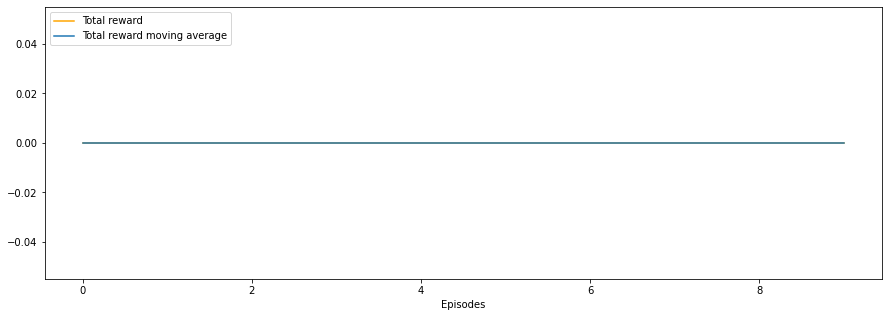

In [ ]:
plot_training_rewards(train_rewards,moving_avg_window_size)

In [ ]:
#dqn_model=build_dqn(action_count=env.action_space.n)
#dqn_model.load_weights('ALE/Freeway-v5_DQN_Weights_5000ep.h5')

In [ ]:
#test with stable library (not working)
from stable_baselines3 import DQN

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("ALE/Freeway-v5")

del model # remove to demonstrate saving and loading

model = DQN.load("ALE/Freeway-v5")

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
